In [15]:
import numpy as np

import torch

import torch.nn as nn

import matplotlib.pyplot as plt

In [223]:
# PROTOTYPING 



num_diffusion_timesteps=1000
scale = 1000 / num_diffusion_timesteps
beta_start = scale * 1e-4
beta_end = scale * 0.02
beta = torch.linspace(
    beta_start,
    beta_end,
    num_diffusion_timesteps,
)

beta = torch.clamp(beta, 0, 0.999)

alpha = 1 - beta
self_sqrt_beta                       = torch.sqrt(beta)
alpha_cumulative                = torch.cumprod(alpha, dim=0)
#alpha_cumulative = torch.clamp(alpha_cumulative, 0, 0.999)
sqrt_alpha_cumulative           = torch.sqrt(alpha_cumulative)
one_by_sqrt_alpha               = 1. / torch.sqrt(alpha)
sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - alpha_cumulative)

x0s = torch.zeros(5)
x0s[0] = 1



def forward_diffusion(x0, timesteps):
    eps = torch.rand_like(x0)  # Noise
    mean    = sqrt_alpha_cumulative[timesteps] * x0  # Image scaled

    std_dev = sqrt_one_minus_alpha_cumulative[timesteps] # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise

    return sample, eps



noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
 


def sf(x):
    return torch.softmax(x,0)
def entropy(x):
    return -torch.sum((x) * torch.log2((x)))

def split_info(k_tot, k_i):
    s1 = torch.sum(k_tot)
    s2 = torch.sum(k_i)
    r1 = s2/s1
    r1_res = 1-r1
    return torch.sum(entropy(r1) + entropy(r1_res))
   
def IG(x0, x1):
    return entropy(sf(x0)) - entropy(sf(x1))

def IGR(x0, x1, k0, k1):
    return IG(x0, x1) / split_info(k0, k1)



x1 = torch.rand(5)
x0 = torch.ones(7) * -0.1
x0[0:4] = x1[:-1]

k1 = torch.ones(5)
k0 = torch.ones(7)

print('Information gain ratio', IGR(x0, x1, k0, k1))

x0 = torch.ones(7) * -0.1
x0[0:5] = x1
print('Information gain ratio', IGR(x0, x1, k0, k1))



Information gain ratio tensor(0.5319)
Information gain ratio tensor(0.7621)


In [47]:
# GRU NN

class GRU_WFC(nn.Module):
    def __init__(self,tile_num, num_match, H, W, iter, kernel_size = 3, bias_scale = 0.25, deep = False):
        super().__init__()

        """
        RAFT has a few more NNs in between the GRU update block. This is probably important cause im pretty sure this netwrok is too small to handle this problem
        """
        self.num_tile = tile_num
        self.map_size = H*W
        self.W = W
        self.H = H
        self.deep = deep
        self.num_iter = iter
        self.bias_scale = bias_scale
        self.num_matches = num_match
        
        self.valid = torch.zeros((self.num_matches, H, W)) / 4.0
        self.flat_valid = torch.zeros((self.num_matches, H * W))
        self.mask = torch.ones((tile_num, H, W))
        self.vmask = torch.zeros((4,H, W))

        if 0:
            self.conv1 = torch.nn.Conv2d(self.num_tile, self.num_tile, 5,1,2) # We append binary validity vector to each space of size = number of possible connections
            self.conv2 = torch.nn.Conv2d(self.num_tile, self.num_tile, 5,1,2) 
            self.conv3 = torch.nn.Conv2d(self.num_tile,self.num_tile, 5,1,2)

        self.k_size = kernel_size
        self.p_size = kernel_size//2

        # Separable convolutions taken straight from RAFT. Just rewrite at some point, or change for another faster convolution idk
        self.convz1 = nn.Conv2d(self.num_tile, self.num_tile, (1,self.k_size), padding=(0,self.p_size))
        self.convr1 = nn.Conv2d(self.num_tile, self.num_tile, (1,self.k_size), padding=(0,self.p_size))
        self.convq1 = nn.Conv2d(self.num_tile*2, self.num_tile, (1,self.k_size), padding=(0,self.p_size))

        self.convz2 = nn.Conv2d(self.num_tile, self.num_tile, (self.k_size,1), padding=(self.p_size,0))
        self.convr2 = nn.Conv2d(self.num_tile, self.num_tile, (self.k_size,1), padding=(self.p_size,0))
        self.convq2 = nn.Conv2d(self.num_tile*2, self.num_tile, (self.k_size,1), padding=(self.p_size,0))

        self.inter_cv1 = nn.Conv2d(self.num_tile, self.num_tile*2, (1,self.k_size), padding=(0,self.p_size))
        self.inter_cv2 = nn.Conv2d(self.num_tile, self.num_tile//2, (1,self.k_size), padding=(0,self.p_size))
        self.inter_cv3 = nn.Conv2d(self.num_tile*2, self.num_tile, (1,self.k_size), padding=(0,self.p_size))
        self.inter_cv4 = nn.Conv2d(self.num_tile//2, self.num_tile, (1,self.k_size), padding=(0,self.p_size))

        self.inter_ch1 = nn.Conv2d(self.num_tile, self.num_tile*2, (self.k_size,1), padding=(self.p_size,0))
        self.inter_ch2 = nn.Conv2d(self.num_tile, self.num_tile//2, (self.k_size,1), padding=(self.p_size,0))
        self.inter_ch3 = nn.Conv2d(self.num_tile*2, self.num_tile, (self.k_size,1), padding=(self.p_size,0))
        self.inter_ch4 = nn.Conv2d(self.num_tile//2, self.num_tile, (self.k_size,1), padding=(self.p_size,0))

        self.inter_skip = nn.Conv2d(self.num_tile*2, self.num_tile, self.k_size, 1, self.p_size)
        self.inter_skip_gate = nn.Conv2d(self.num_tile, self.num_tile, self.k_size, 1, self.p_size)

        self.sigma = torch.nn.Sigmoid()
        self.phi = torch.nn.Tanh()
        self.lRel = torch.nn.LeakyReLU(0.2)
        self.pad = torch.nn.ZeroPad2d(1)
       

    def forward(self, h, steps, training):
        """
        input: initial white noise block shape [manifold number, tile count, height, width], training boolean: if true retain each diffusion prediciton, if false only retain final map
        returns: either collapsed map or collapsed map with intermediary diffusion steps for training 
        """
        collapsed = False
        iter = 0


        while (iter < steps-1):
            #h = self.collapse(h, k)
            # Check for collapse or something
            # h = [1, num_tiles, w, h]
            if self.deep:
                h = self.deeper_collapse(h)
            if 0:

                xskipv = h.clone()
                xskiph = h.clone()
                
                v1 = self.inter_cv1(xskipv)
                v2 = self.phi(self.inter_cv3(v1))
                v3 = self.lRel(self.inter_cv2(xskipv))
                v4 = self.sigma(self.inter_cv4(v3))
                xskipv = xskipv * (1 - v4) + v2 * self.bias_scale
    
                h1 = self.inter_ch1(xskiph)
                h2 = self.phi(self.inter_ch3(h1))
                h3 = self.lRel(self.inter_ch2(xskiph))
                h4 = self.sigma(self.inter_ch4(h3))
                xskiph = xskiph * (1 - h4) + h2 * self.bias_scale

                xskip = torch.concat((xskipv, xskiph), dim=1)
                xskip = self.sigma(self.inter_skip(xskip))

                gate = self.sigma(self.inter_skip_gate(h))
                h = h * (1 - gate) + self.phi(xskip) * gate # Scale reduction for stability hopefully

                h = h * self.mask

            h = self.collapse(h)

            h = h #* self.mask
            
            if training:
                if iter == 0:
                    h_ret = h.clone().unsqueeze(1)
                else:
                    h_ret = torch.concat((h_ret, h.clone().unsqueeze(1)), dim = 1)

            if collapsed:
                break
            iter += 1
            
        if training:
            return h_ret
        else:
            return h
        
    def collapse(self, h): # h is memory block. becomes map after pseudo wfc, key matrix
            
            #self.key_query(h, k)
            #print('-----',h.shape, self.valid.shape)
            x = h #torch.concat((h,self.valid.unsqueeze(0)),dim=1) # Append a binary vector to each wave space representing valididty w.r.t. each neighbor

            # horizontal
            hx = x
            z = torch.sigmoid(self.convz1(hx))
            r = torch.sigmoid(self.convr1(hx))
            q = torch.tanh(self.convq1(torch.concat((r*h, x),dim=1)))        
            h = (1-z) * h + z * q

            # vertical
            hx = x
            z = torch.sigmoid(self.convz2(hx))
            r = torch.sigmoid(self.convr2(hx))
            q = torch.tanh(self.convq2(torch.concat((r*h, x),dim=1)))       
            h = (1-z) * h + z * q

            return h
    
    def deeper_collapse(self, h):
        xskipv = h.clone()
        xskiph = h.clone()
        
        v1 = self.inter_cv1(xskipv)
        v2 = self.phi(self.inter_cv3(v1))
        v3 = self.lRel(self.inter_cv2(xskipv))
        v4 = self.sigma(self.inter_cv4(v3))
        xskipv = xskipv * (1 - v4) + v2 * self.bias_scale

        h1 = self.inter_ch1(xskiph)
        h2 = self.phi(self.inter_ch3(h1))
        h3 = self.lRel(self.inter_ch2(xskiph))
        h4 = self.sigma(self.inter_ch4(h3))
        xskiph = xskiph * (1 - h4) + h2 * self.bias_scale

        xskip = torch.concat((xskipv, xskiph), dim=1)
        xskip = self.sigma(self.inter_skip(xskip))

        gate = self.sigma(self.inter_skip_gate(h))
        h = h * (1 - gate) + self.phi(xskip) * gate # Scale reduction for stability hopefully

        h = h * self.mask

        return h

    def key_query(self, x, key):
        x = (torch.softmax(x.clone(), dim=1))
        x_pad = x.clone()
   
        y_right = x_pad[0, :, :, :-1].flatten(-2,-1)
        y_left = x_pad[0, :, :, 1:].flatten(-2,-1)
        y_up = x_pad[0, :, :-1, :].flatten(-2,-1)
        y_down = x_pad[0, :, 1:, :].flatten(-2,-1)


        #--------- Conditional joint probbility [ C =  (1 - sum([Y x X] * K) / X) ] + inf/nan mask
        if 1:
            pu_wrt_d = self.pad(self.conprob(y_up, y_down, key).permute(2,1,0).reshape(2, self.H-1, self.W))
            pd_wrt_u = self.pad(self.conprob(y_down, y_up, key).permute(2,1,0).reshape(2, self.H-1, self.W))
            pl_wrt_r = self.pad(self.conprob(y_right, y_left, key).permute(2,1,0).reshape(2,self.H,self.W-1))
            pr_wrt_l = self.pad(self.conprob(y_left, y_right, key).permute(2,1,0).reshape(2,self.H,self.W-1))

        #--------- Oringial = [ C = Y x K x X ]
        if 0:
            pred_v = torch.matmul(key, y_up.squeeze())
            #pred_v = pred_v.T
            error_v =  y_down * pred_v # torch.matmul(y_down.permute(1,0).unsqueeze(1), pred_v.unsqueeze(-1)).reshape(1, self.H-1, self.W)

            pred_vd = torch.matmul(key, y_down.squeeze())
            error_vd = y_up * pred_vd
            #pred_vd = pred_vd.T
            #error_vd = torch.matmul(y_up.permute(1,0).unsqueeze(1), pred_vd.unsqueeze(-1)).reshape(1, self.H-1, self.W)

            pred_h = torch.matmul(key, y_right.squeeze())
            error_h = y_left * pred_h
            #pred_h = pred_h.T
            #error_h = torch.matmul(y_left.permute(1,0).unsqueeze(1), pred_h.unsqueeze(-1)).reshape(1,self.H,self.W-1)

            pred_hl = torch.matmul(key, y_left.squeeze())
            error_hl = (y_right * pred_hl)
            #pred_hl = pred_hl.T
            #error_hl = torch.matmul(y_right.permute(1,0).unsqueeze(1), pred_hl.unsqueeze(-1)).reshape(1,self.H,self.W-1)

            error_v = self.pad(error_v.reshape(2, self.H-1, self.W))
            error_h = self.pad(error_h.reshape(2,self.H,self.W-1))
            error_vd = self.pad(error_vd.reshape(2, self.H-1, self.W))
            error_hl = self.pad(error_hl.reshape(2,self.H,self.W-1))

        
        error_v = pu_wrt_d
        bd = error_v[:,1:,1:-1] # 
        bd[:,9] =(bd[:,9] - 1) # -1 on bottom most row

        error_vd = pd_wrt_u
        bu = error_vd[:,:-1,1:-1]
        bu[:,0] = (bu[:,0] - 1) # -1 on top most row

        error_h = pr_wrt_l
        bl= error_h[:,1:-1,:-1].transpose(-2,-1)
        bl[:,0] = (bl[:,0] - 1) # -1 on left most column

        error_hl = pl_wrt_r
        br = error_hl[:,1:-1,1:].transpose(-2,-1)
        br[:,9,:] = (br[:,9,:] - 1).squeeze() # -1 of right most column

        vmask = torch.concat((bd.unsqueeze(0),bu.unsqueeze(0),bl.transpose(-2,-1).unsqueeze(0),br.transpose(-2,-1).unsqueeze(0)),dim=1)        
        self.reset_mask()
        ones = torch.ones(8, self.H, self.W)
        self.valid =  ones * vmask.squeeze()
        self.vmask = vmask.clone()

    def conprob(self, x, y, k):
        # Computes the conditional joint probability between two wave spaces
        t1 = x.transpose(-2,-1).unsqueeze(1).clone()
        t2 = y.transpose(-2,-1).unsqueeze(1).clone()
        keytemp = k.clone()

        test = torch.matmul(t2.transpose(-2,-1), t1)
        test = torch.sum((keytemp.unsqueeze(0).unsqueeze(0) * test.unsqueeze(1)), dim = 2)
        test = self.infnan_mask(test)


        return test

    def reset_mask(self):
        self.valid = self.valid * 0
        self.valid = self.valid + 1/8.0

    def infnan_mask(self, x):
        # ******* This function is taken straight from stack overflow not my code: https://stackoverflow.com/questions/64594493/filter-out-nan-values-from-a-pytorch-n-dimensional-tensor
        shape = x.shape
        tensor_reshaped = x.reshape(shape[0],-1).clone()
        #Drop all rows containing any nan:
        tensor_reshaped = tensor_reshaped[~torch.any(tensor_reshaped.isnan(),dim=1)]
        # I just copied the same thing but for inf
        tensor_reshaped = tensor_reshaped[~torch.any(tensor_reshaped.isinf(),dim=1)]
        #Reshape back:
        x = tensor_reshaped.reshape(tensor_reshaped.shape[0],*shape[1:])

        return x


In [4]:


def wfc_loss(map, key):
    """
    Takes predicted map and returns a bainary map indicating valid vetical and horizontal connections accoriding the the maximum probability
    """
    x = torch.softmax(map.squeeze().flatten(-2,-1), dim=0)
    
    with torch.no_grad():
        val, id = x.max(dim=0, keepdim = True)
        mask = torch.zeros_like(x)
        id_l = torch.arange(100)
        mask[id[0,:],id_l[:]] = 1

    x_pad = x.reshape(map.shape) #torch.ceil((x * mask)).reshape(map.shape)
   
    y_right = x_pad[0, :, :, :-1].flatten(-2,-1)
    y_left = x_pad[0, :, :, 1:].flatten(-2,-1)
    y_up = x_pad[0, :, :-1, :].flatten(-2,-1)
    y_down = x_pad[0, :, 1:, :].flatten(-2,-1)

    pred_v = torch.matmul(key, y_up.squeeze())
    pred_v = pred_v.T
    error_v = torch.matmul(y_down.permute(1,0).unsqueeze(1), pred_v.unsqueeze(-1))

    pred_vd = torch.matmul(key, y_down.squeeze())
    pred_vd = pred_vd.T
    error_vd = torch.matmul(y_up.permute(1,0).unsqueeze(1), pred_vd.unsqueeze(-1))

    pred_h = torch.matmul(key, y_right.squeeze())
    pred_h = pred_h.T
    error_h = torch.matmul(y_left.permute(1,0).unsqueeze(1), pred_h.unsqueeze(-1))

    pred_hl = torch.matmul(key, y_left.squeeze())
    pred_hl = pred_hl.T
    error_hl = torch.matmul(y_right.permute(1,0).unsqueeze(1), pred_hl.unsqueeze(-1))

    return error_v, error_vd, error_h, error_hl

def infnan_mask(x):
        # ******* This function is taken straight from stack overflow not my code: https://stackoverflow.com/questions/64594493/filter-out-nan-values-from-a-pytorch-n-dimensional-tensor
        shape = x.shape
        tensor_reshaped = x.reshape(shape[0],-1).clone()
        #Drop all rows containing any nan:
        tensor_reshaped = tensor_reshaped[~torch.any(tensor_reshaped.isnan(),dim=1)]
        # I just copied the same thing but for inf
        tensor_reshaped = tensor_reshaped[~torch.any(tensor_reshaped.isinf(),dim=1)]
        #Reshape back:
        x = tensor_reshaped.reshape(tensor_reshaped.shape[0],*shape[1:])

        return x

def conprob(x, y, k):
        # Computes the conditional joint probability between two wave spaces
        t1 = x.transpose(-2,-1).unsqueeze(1).clone()
        t2 = y.transpose(-2,-1).unsqueeze(1).clone()
        keytemp = k.clone()
        
        test = torch.matmul(t2.transpose(-2,-1), t1)
        test = torch.sum((keytemp.unsqueeze(0).unsqueeze(0) * test.unsqueeze(1)), dim = 2)
        test = infnan_mask(test)

        return test

smax = torch.nn.Softmax(dim=1)
def wfc_loss_2(map, key):
    map = (torch.softmax(map, dim=1))
    x_pad = map

    y_right = x_pad[0, :, :, :-1].flatten(-2,-1)
    y_left = x_pad[0, :, :, 1:].flatten(-2,-1)
    y_up = x_pad[0, :, :-1, :].flatten(-2,-1)
    y_down = x_pad[0, :, 1:, :].flatten(-2,-1)

    #--------- Conditional joint probbility [ C =  (1 - sum([Y x X] * K) / X) ] + inf/nan mask
    
    p1 = (conprob(y_up, y_down, key).permute(2,1,0))
    p2 = (conprob(y_down, y_up, key).permute(2,1,0))
    p3 = (conprob(y_right, y_left, key).permute(2,1,0))
    p4= (conprob(y_left, y_right, key).permute(2,1,0))

    return p1, p2, p3, p4


In [17]:
# ACTUAL WFC

def actual_wfc(tile_space, width, height, key, seed, z):

    wave_map = torch.ones((tile_space, width, height))
    collapse_index = torch.zeros(width * height)

    #if seed != None:
    wave_map = wave_map * seed
    collapse_index[z] = 1

    wave_map = diffuse(wave_map, z//width, z%width, key, width, height)

    key = key
    collapsed = False
    count = 0
    if 1:
        while not collapsed:
            id_lin = choose(wave_map, collapse_index)
            if id_lin >= 0:
                cx = id_lin % width
                cy = id_lin // width

                wave_vec = wave_map[:,cy, cx].squeeze() #key_return(wave_map, cy, cx, height, width, key, 4)
                tile = collapse(wave_vec)

                wave_map[:, cy, cx] = tile
                wave_map = diffuse(wave_map, cy, cx, key, width, height)
                
                collapse_index[cx + cy * width] = 1

                if collapse_index.sum() == width * height or count > width*height + 10:
                    collapsed = True
                    if count > width*height + 10:
                        print('out of time')
                    break

                count += 1

    return wave_map

def diffuse(map_, cy, cx, k, w, h):
    cy = int(cy)
    cx = int(cx)
    vec = map_[:, cy, cx].unsqueeze(-1)

    if cy-1 >= 0:
        map_[:, cy-1,cx] = map_[:, cy-1,cx] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)
    if cy+1 < h:
        map_[:, cy+1,cx] = map_[:, cy+1,cx] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)
    if cx-1 >= 0:
        map_[:, cy, cx-1] = map_[:, cy, cx-1] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)
    if cx+1 < w:
        map_[:, cy, cx+1] = map_[:, cy, cx+1] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)

    return map_

def collapse(x): 
    # X is current wavespace legality key
    
    probability = torch.softmax(torch.rand_like(x), dim=0) #*torch.softmax(freq, dim=0)
    likelihood = x * probability #torch.matmul(key.T, probability.T)
    _, tile_choice = torch.max(likelihood, dim=0)
    x_collapse = torch.zeros_like(x)
    x_collapse[tile_choice] = 1

    return x_collapse
    
def key_return(map, cy, cx, h, w, key, num_adj):
    """
    Unused cause it was wrong
    
    """
    vspace = torch.zeros(4, map.shape[0])
    epsilon = 1e-3
    if cy-1 >= 0:
        vspace[0] = map[:,cy-1,cx]
    else:
        vspace[0,:] = 1
    if cy+1 < h:
        vspace[1] = map[:,cy+1,cx]
    else:
        vspace[1,:] = 1
    if cx-1 >= 0:
        vspace[2] = map[:,cy, cx-1]
    else:
        vspace[2,:] = 1
    if cx+1 < w:
        vspace[3] = map[:,cy, cx+1]
    else:
        vspace[3,:] = 1

    vspace = torch.clamp(torch.matmul(key.unsqueeze(0), vspace.unsqueeze(-1)).squeeze(), 0, 1)
    vspace = (torch.sum(vspace, dim=0) + epsilon) // num_adj

    return vspace

def choose(map_, collapse_list):
    x_sum = torch.sum(map_,dim=0)
    x_sumf = x_sum.flatten()
    v, id = x_sumf.sort()
    idx = -1

    for k in range((v.shape[0])):
        if collapse_list[id[k]] == 0:
            idx = id[k]
            break

    return int(idx)

def validator(x, key):
    valid = True
    vmap = torch.ones_like(x)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            tile = int(x[j, i])
            
            if j-1 >= 0:
                if key[tile, int(x[j-1,i])] == 0:
                    valid = False
                    vmap[j,i] -= 1

            if j+1 < x.shape[1]:
                if key[tile, int(x[j+1,i])] == 0:
                    valid = False
                    vmap[j,i] -= 1     

            if i-1 >= 0:
                if key[tile, int(x[j,i-1])] == 0:
                    valid = False
                    vmap[j,i] -= 1

            if i+1 < x.shape[0]:
                if key[tile, int(x[j,i+1])] == 0:
                    valid = False
                    vmap[j,i] -= 1
 

    return valid, torch.clamp(vmap, 0, 1)

def gen_key(num_tiles, h, w):
    map_init = torch.randint(0, num_tiles, (h, w)) # [H, W]
    #  Key format: KEY[VALUE, QUERY] -> query is neighbor, value is us tile, returns validity of us given neighbor

    key = torch.zeros(( num_tiles, num_tiles))# [1, N, N]
    for j in range(w):
        for i in range(h):
            
            if i+1 < h:
                key[map_init[i, j], map_init[i+1, j]] = 1 
            if i-1 >= 0:
                key[map_init[i, j], map_init[i-1, j]] = 1 

            if j+1 < w:
                key[map_init[i, j], map_init[i, j+1]] = 1 
            if j-1 >= 0:
                key[map_init[i, j], map_init[i, j-1]] = 1 

    return key

def gen_seed(num_tiles, height, width):
    seed = torch.ones((num_tiles, width, height))
    xy = torch.randint(0, height, (2,1))
    z = torch.randint(0, num_tiles, (1,1))
    seed[:,xy[0], xy[1]] = seed[:,xy[0], xy[1]]*0
    seed[z,xy[0], xy[1]] = 1

    return seed, xy[1]+xy[0]*width

def gen_map(key, h, w, nt):

    iter = 0
    valid = False

    while valid == False:
        valid = False
        seed, z = gen_seed(nt, h, w)
        map_ = actual_wfc(nt, w, h, key, seed, z).squeeze()
        val, id = torch.max(map_.flatten(-2,-1),dim=0)
        id_map = id.reshape(h,w)
        valid, vmap = validator(id_map, key)
        iter += 1
    
    if iter > 10:
        print('shit')
    
    return map_, id_map


In [18]:
# DIFFUSION CLASS 

class diffusion():
    def __init__(self):
        self.num_diffusion_timesteps=1000
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        beta = torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
        )

        beta = torch.clamp(beta, 0, 0.999)

        self.alpha = 1 - beta
        self.self_sqrt_beta = torch.sqrt(beta)
        self.alpha_cumulative = torch.cumprod(self.alpha, dim=0)
        #alpha_cumulative = torch.clamp(alpha_cumulative, 0, 0.999)
        self.sqrt_alpha_cumulative = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)


    def forward_diffusion(self, x0, timesteps, beta_time, epsilon_prior = 0):

        if epsilon_prior.sum() == 0: # We diffuse forward, then check for entropy threshold, then if exceeded we go back in time and idffuse new keys forwar as well with same epsilon
            eps = torch.rand_like(x0) 
        else:
            eps = epsilon_prior
        
        indices = timesteps[beta_time]
        mean = self.sqrt_alpha_cumulative[indices] * x0  # Map scaled
        std_dev = self.sqrt_one_minus_alpha_cumulative[indices] # Noise scaled
        sample  = mean + std_dev * eps # scaled inputs * scaled noise

        return sample, eps

    def do_diffusion(self, x0, key):
        
        # x0 is a 3d

        noisy_images = x0.squeeze().clone().unsqueeze(0)
        xts_threshold = x0.clone()
        xts = x0.clone()

        specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999] # This less represents the "timesteps" in diffusion and more the "rate" of diffusion. 
        timestep = torch.as_tensor(specific_timesteps, dtype=torch.long)
        beta_index = timestep.shape[0]
        beta_time = torch.zeros_like(x0)
        z = torch.zeros(1)
        #beta_time = torch.as_tensor(beta_time, dtype=torch.long)

        x_key_mask = self.uncollapse(x0.clone(), key)

        diffusing = True
        itr = 0
        while diffusing:
            xPrior = xts
            betaPrior = beta_time.clone()

            # Take forward diffusion step
            xts, eps = self.forward_diffusion(xPrior.clone(), timestep, torch.as_tensor(beta_time, dtype=torch.long), z)

            # Update mask according to entropy threshold -> uncollapse valididty 
            xts_threshold[beta_time >= 3] = 1
            x_key_mask = uncollapse(xts_threshold, key) 
            beta_time += torch.ones_like(beta_time) * x_key_mask
            beta_time = torch.clamp(beta_time, 0, beta_index-1)

            # "re-perform" diffusion using retcon'd beta index
            xts, _ = self.forward_diffusion(xPrior.clone(), timestep, torch.as_tensor(beta_time, dtype=torch.long), eps)

            noisy_images = torch.concat((xts.unsqueeze(0), noisy_images), dim = 0)

            itr += 1

            if betaPrior.sum() == beta_time.sum():
                # Beta time will increase each loop as we march through diffusion, but will stay static when we finish or cannot uncollapse any more
                diffusing = False

        return noisy_images, itr
    
    def uncollapse(self, wave_map, key):
        diff_map = torch.ones_like(wave_map)

        for i in range(wave_map.shape[1]):
            for j in range(wave_map.shape[2]):
                
                if j-1 >= 0:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j-1, i]))#/wave_map[:, j-1, i].sum())

                if j+1 < wave_map.shape[1]:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j+1, i]))#/wave_map[:, j+1, i].sum())
                        
                if i-1 >= 0:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i-1]))#/wave_map[:, j, i-1].sum())

                if i+1 < wave_map.shape[2]:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i+1]))#/wave_map[:, j, i+1].sum())

        for k in range(wave_map.shape[0]):
            for i in range(wave_map.shape[1]):
                for j in range(wave_map.shape[2]):
                    if diff_map[k,j,i] >= 4:
                        diff_map[k,j,i] = 1
                    else:
                        diff_map[k,j,i] = 0


        return diff_map






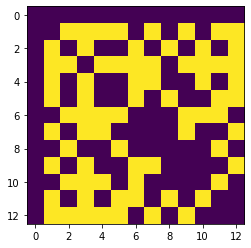

In [85]:
# Data loading block: Generate key, Generate maps, Diffuse maps



df = diffusion()


train_size = 100
num_tiles = 13
height = 6
width = 6
#key = gen_key(num_tiles, 6, 6)
maps_training = torch.zeros(train_size, 50, num_tiles, height, width)
diffusion_steps = torch.zeros(train_size)
plt.imshow(key.squeeze().numpy())
with torch.no_grad():
    for m in range(train_size):
        x, i_l = gen_map(key, height, width, num_tiles)
        #for d in range(manifold_count):
        df_unroll, itr = df.do_diffusion(x, key)

        if itr < 50:
            maps_training[m, 0:itr+1, :, :, :] = df_unroll.clone()
            diffusion_steps[m] = itr

        else:
            print('whoops')

        



In [213]:
# OLD ------- DIFFUSION PROCESS ------ OLD

"""
Let's try to numerically diffuse the map into noise as the base DDPM method. 
Followed by "undoing" decisions systematically according to the surpise of a value and adding the tile
to a companion wave space indicating tiles we COULD place if we so wanted to.
0.0 Copy current collapsed map. This will be a binary map representing what can be placed.
    1. when surpise goes below a threshold we "undo" one step of collapse:
        1.2 Check legal spaces given 
    adding some value to it and all legal tiles in the wave space, then softmaxing it. 
    2. continue to diffuse with DDPM
    3. Whenever a value goes below the surprise threshold, we add 
"""

tau = torch.ones(1) * 100
s = 0.008
beta_schedule = torch.zeros((100))
al =  torch.zeros((100))

for t in range(100):

    f1 = torch.cos(((t+1) / tau + s) / (1 + s) * torch.pi / 2) ** 2
    f0 = torch.cos((t / tau + s) / (1 + s) * torch.pi / 2) ** 2

    alpha = f1 / f0
    al[t] = alpha

    beta_schedule[t] = 1 - alpha




def diffuse_uncertainty(x, beta, x_key, beta_time):
    y = torch.rand_like(x) * x_key#
    x = y*np.sqrt(1-beta) + x*np.sqrt(beta)
    
    for t in range(beta.shape[0]):
        for j in range(beta.shape[1]):
            for i in range(beta.shape[2]):
                
                if x_key[t,j,i] == 1:
                    beta[t, j, i] = beta_schedule[beta_time[t, j, i]]
                    beta_time[t, j, i] += 1

    return x, torch.clamp(beta, 0, 1)

def uncollapse(wave_map, key):
    diff_map = torch.ones_like(wave_map)

    for i in range(wave_map.shape[1]):
        for j in range(wave_map.shape[2]):
            
            if j-1 >= 0:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j-1, i]))#/wave_map[:, j-1, i].sum())

            if j+1 < wave_map.shape[1]:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j+1, i]))#/wave_map[:, j+1, i].sum())
                    
            if i-1 >= 0:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i-1]))#/wave_map[:, j, i-1].sum())

            if i+1 < wave_map.shape[2]:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i+1]))#/wave_map[:, j, i+1].sum())



    for k in range(wave_map.shape[0]):
        for i in range(wave_map.shape[1]):
            for j in range(wave_map.shape[2]):
                if diff_map[k,j,i] >= 4:
                    diff_map[k,j,i] = 1
                else:
                    diff_map[k,j,i] = 0


    return diff_map
 
#def information_uncertainty(x):

def sf(x):
    return torch.softmax(x, 0)

def information(x, xo):
    # input: wave vector
    epsilon = 0.05
    z = torch.ones(1) * x.shape[0]
    max_ent = torch.sum(torch.log2(z))
    entropy = torch.sum(-torch.log2(x)*x)

    residual = torch.ones(xo.shape[0] - x.shape[0]) * epsilon
    e_sans = torch.sum(-torch.log2(residual) * residual)

    zo = torch.ones(1) * xo.shape[0]
    max_ento = torch.sum(torch.log2(zo))
    entropyo = torch.sum(-torch.log2(xo)*xo)

    
    ii = torch.ones(1) * (x.shape[0] / xo.shape[0])
    ii_ = ii * -torch.log2(ii) + (1-ii) * -torch.log2(1-ii)

    print('---- new, old',entropy, entropyo)


    gain_ratio = (entropyo - entropy * ii - e_sans * (1 - ii)) / ii_

    print('Entropy gain', entropyo - entropy * ii)
    print('Gain ratio', gain_ratio)
    print()
    #return entropy
    



def diffuse_wrapper(map_, key, thresh, step_size):


    threshold = thresh
    beta = torch.ones_like(map_)
    beta_time = torch.zeros_like(beta)

    x_key_mask = uncollapse(map_.clone(), key)
    
    x_key_threshold = map_.clone()
    x_ = map_.clone()
    map_unroll = map_.clone().unsqueeze(0)
    iter = 0
    while beta.sum() > 0:
        cp = beta.sum()
        x_, beta = diffuse_uncertainty(x_, beta, x_key_mask, beta_time)

        for i in range(x_.shape[1]):
            for j in range(x_.shape[2]):
                entropy = torch.nonzero(x_[:,j,i])
                s = entropy.shape[0]
                entropy = torch.sum(-torch.log2((x_[entropy, j, i]))*(x_[entropy, j, i]))
                
                for k in range(x_.shape[0]):
                    if x_[k,j,i] > 0:
                        if (-torch.log2(x_[k,j,i])*x_[k,j,i] - entropy/s).abs() < threshold:
                            # Key threshold controls the validity diffusion
                            x_key_threshold[k,j,i] = 1

        # Key mask controls the noise diffusion. Masks the Beta parameter 
        x_key_mask = uncollapse(x_key_threshold, key) 

        map_unroll = torch.concat((x_.unsqueeze(0), map_unroll), dim=0)
        if beta.sum() == cp:
            print('huh')
            break
    return map_unroll



if 0:
    sigma = 0.05**2
    #x = torch.rand(5)
    k1 = torch.zeros(10)
    k2 = torch.zeros(10)

    k1[0:3] = 1
    k1[7:-1] = 1

    k2[2:5] = 1

    xn = torch.ones(10) * sigma
    xn[0:5] = x
    xn = sf(xn)

    xk1 = xn*k1
    xk2 = xn*k2
    xk1 = (xk1[torch.nonzero(xk1)])
    xk2 = (xk2[torch.nonzero(xk2)])

    print(xk1)
    print(xk2)

    r1 = k1.sum() / 10
    r2 = k2.sum() / 10

    ii1 = -r1*torch.log2(r1) - (1-r1)*torch.log2((1-r1))
    ii2 = -r2*torch.log2(r2) - (1-r2)*torch.log2((1-r2))

    ek1 = torch.sum(-torch.log2(xk1)*xk1) / ii1
    ek2 = torch.sum(-torch.log2(xk2)*xk2) / ii2

    print(ek1, ek2, ii1, ii2)


if 0:
    print('key 4->6')
    information( x, x_old)
    print('key 4->8')
    information( x, x_old_2)


    print('key 4->6')
    x_old_ = torch.ones(6) * 0.05
    x_old_[0:4] = x.clone() * 0.3
    information( x, x_old_)


    print('key 4->8')
    x_old_2_ = torch.ones(8) * 0.05
    x_old_2_[0:4] = x.clone() * 0.3
    information( x, x_old_2_)





Key generated



Text(0.5, 1.0, 'Binary key matrix')

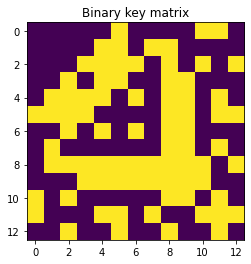

In [177]:
# OLD -------------- DATA LOADING --------- OLD

num_tiles = 13
wratio = 6
hratio = 6
map_h = 6
map_w = 6
entropy_thresh = 0.1
beta = 0.05
train_size = 10 # Number of maps in training dataset
test_size = 1
manifold_count = 4 # Number of different diffusions routes for each map 
diffusion_steps = 60
diffusion_step_list = torch.zeros(train_size, manifold_count)
map_20 = torch.zeros((train_size, manifold_count, diffusion_steps, num_tiles, map_h, map_w)) 

key_valid = False
while key_valid == False:
    key = gen_key(num_tiles, wratio, hratio)
    key_valid = True
    for i in range(key.shape[0]):
        if key[i,:].sum() == 0:
            key_valid = False

print('Key generated')
with torch.no_grad():
    for k in range(train_size):
        
        map_f, id_map = gen_map(key, map_h, map_w, num_tiles)

        for m in range(manifold_count):
            map_ = diffuse_wrapper(map_f.clone(), key, entropy_thresh, beta)
            #index = np.linspace(0,map_.shape[0]-1, diffusion_steps)
            diffusion_step_list[k, m] = map_.shape[0]
            map_20[k, m, 0:map_.shape[0]] = map_

print()

plt.figure(1)
plt.imshow(key.numpy())
plt.title('Binary key matrix')




seed xyz: tensor([4]) tensor([12]) tensor([[6]])


/var/folders/d6/9_0p0ctd5cd5q3f8lhpbzpc40000gn/T/ipykernel_67184/2224842711.py:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  wave_map = diffuse(wave_map, z//width, z%width, key, width, height)


True


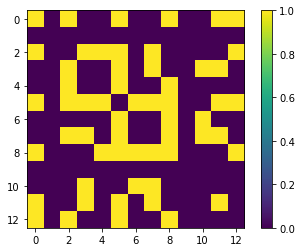

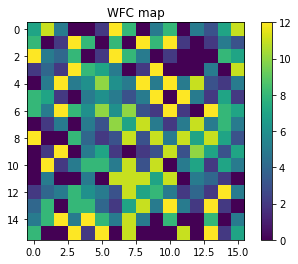

In [630]:
# PROTOTYPING

num_tiles = 13

width = 16
height = width 

h = 5
w = 5
map_init = torch.randint(0, num_tiles, (h, w)) # [H, W]
map_init = (map_init)

#  Key format: KEY[VALUE, QUERY] -> query is neighbor, value is us tile, returns validity of us given neighbor

if 1:
    key = torch.zeros(( num_tiles, num_tiles))# [1, N, N]
    for j in range(w):
        for i in range(h):
            
            if i+1 < h:
                key[map_init[i, j], map_init[i+1, j]] = 1 
            if i-1 >= 0:
                key[map_init[i, j], map_init[i-1, j]] = 1 

            if j+1 < w:
                key[map_init[i, j], map_init[i, j+1]] = 1 
            if j-1 >= 0:
                key[map_init[i, j], map_init[i, j-1]] = 1 


    key = key #torch.clamp(key - torch.eye(num_tiles).squeeze(), 0, 1)

if 0:
    plt.figure(1)
    plt.imshow(key.squeeze().numpy())
    plt.title('WFC key')

if 1:
    seed = torch.ones((num_tiles, width, height))
    xy = torch.randint(0, height, (2,1))
    #xy[1] = 0
    #xy[0] = 1
    z = torch.randint(0, num_tiles, (1,1))
    seed[:,xy[0], xy[1]] = seed[:,xy[0], xy[1]]*0
    seed[z,xy[0], xy[1]] = 1

    print('seed xyz:', xy[1], xy[0], z)



map_ = actual_wfc(num_tiles, width, height, key, seed, xy[1]+xy[0]*width).squeeze()

val, id = torch.max(map_.flatten(-2,-1),dim=0)
id_map = id.reshape(height,width)

valid, vmap = validator(id_map, key)
print(valid)

plt.figure(1)
plt.imshow(key)
plt.colorbar()

plt.figure(2)
plt.imshow(id_map.squeeze().numpy())
plt.title('WFC map')
plt.colorbar()

if 0:
    plt.figure(3)
    plt.imshow(id_map_old.squeeze().numpy())
    plt.title('WFC map old')
    plt.colorbar()


    id_map_old = id_map


tensor([0., 1., 1., 1., 1., 1., 1., 1.])
tensor([[7, 0, 1],
        [1, 0, 1],
        [0, 5, 6]])
tensor([[1, 1, 6, 2, 0],
        [5, 2, 6, 7, 6],
        [7, 7, 4, 1, 6],
        [2, 6, 1, 0, 5],
        [5, 7, 3, 5, 0]])


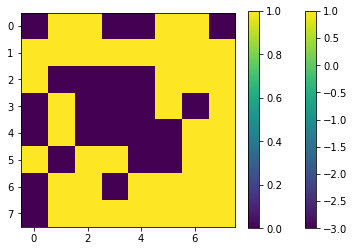

In [537]:
# PROTOTYPING 

def post_process(id_map, v_map, key):
    id_vec = torch.arange(key.shape[0])
    for threshold in range(4):
        for i in range(id_map.shape[0]):
            for j in range(id_map.shape[1]):
                if vmap[j, i] == threshold - 3:
                    t = 0





print(key[7,:])

valid, vmap = validator(id_map, key)

print(id_map[0:3,0:3])

plt.imshow(vmap)
plt.colorbar()

print(map_init)




tensor([[1, 1, 6, 2, 0],
        [5, 2, 6, 7, 6],
        [7, 7, 4, 1, 6],
        [2, 6, 1, 0, 5],
        [5, 7, 3, 5, 0]])


 ij 1 , 0 map val tensor(5)
tensor([0., 1., 0., 0., 0., 1., 0., 0.])
 ij 1 , 1 map val tensor(2)
tensor([0., 1., 1., 0., 0., 1., 1., 0.])
 ij 1 , 2 map val tensor(6)
tensor([0., 1., 1., 0., 0., 1., 1., 0.])
 ij 1 , 3 map val tensor(7)
tensor([1., 1., 1., 1., 1., 1., 1., 0.])
 ij 1 , 4 map val tensor(6)
tensor([1., 1., 1., 1., 1., 1., 1., 1.])
tensor(6) tensor(0)



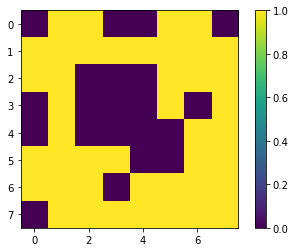

In [542]:
# PROTOTYPING 

print(map_init)
print()
print()
key2 = torch.zeros_like(key)
for j in range(w):
        for i in range(h):


            if i+1 < h:
                key2[map_init[i, j], map_init[i+1, j]] = 1 
            if i-1 >= 0:
                key2[map_init[i, j], map_init[i-1, j]] = 1 

            if j+1 < w:
                key2[map_init[i, j], map_init[i, j+1]] = 1 
            if j-1 >= 0:
                key2[map_init[i, j], map_init[i, j-1]] = 1 

            if i == 1:
                 print(' ij', i, ',',j, 'map val', map_init[i,j])
                 print(key2[i,:])
                 if j == 4:
                      print(map_init[i, j], map_init[i-1, j])
print()

plt.figure(1)
plt.imshow(key2)
plt.colorbar()

5


In [83]:
# TRAIN LOOP

epochs = 100
width = 10 #map_w
height = 10 #map_h
num_tiles = num_tiles
diffusion_steps_GRU = 20
kernel_size = 3
l_sum_np = 0
batch_size = 20
loss = 0

index_list = np.arange(train_size)

gru = GRU_WFC(num_tiles, 0, height, width, diffusion_steps_GRU, kernel_size, bias_scale = 0.25, deep = False)

loss_func =  nn.MSELoss() # nn.L1Loss() #
l_kl = torch.nn.KLDivLoss(reduction="batchmean", log_target = True)
lbce = nn.BCEWithLogitsLoss()

#loss_l1 = nn.L1Loss()
optimizer = torch.optim.NAdam(gru.parameters(), lr = 0.001)

map_ = torch.zeros(train_size, 13, height, width)
for ii in range(train_size):
    map_[ii] = maps_training[ii, int(diffusion_steps[ii]), :, :, :]


_, id_set = torch.max(map_, dim = 1)

va, m = (torch.var_mean(id_set.float(), 0))
print('The training dataset has a mean of ', m.mean(),'and var of ', va.mean())


#truth_h = torch.zeros((height-1)*width*num_tiles)
#truth_v = torch.zeros(height*(width-1)*num_tiles)


#truth_h = torch.zeros(1)
#truth_v = torch.zeros(1)

#key = torch.zeros(( num_tiles, num_tiles))# [1, N, N]
#map_init = torch.randint(0, num_tiles, (height, width)) # [H, W]

#map_init = torch.randint(1, num_tiles, (8, 8)) # [H, W]
#map_init = pad(map_init)
#cancel = 1-torch.eye(num_tiles)

if 0:
    for i in range(8):
        for j in range(8):
            
            if i+1 < height:
                key[map_init[i, j], map_init[i+1, j]] = 1 
            if i-1 > 0:
                key[map_init[i, j], map_init[i-1, j]] = 1 

            if j+1 < width:
                key[map_init[i, j], map_init[i, j+1]] = 1 
            if j-1 > 0:
                key[map_init[i, j], map_init[i, j-1]] = 1 

#key = key*cancel
#key = torch.ones((2,2)) - torch.eye(2)

#gru_mask_init = torch.ones(num_tiles, height, width)

for epoch in range(epochs):
    loss = 0
    v_ratio = 0
    np.random.shuffle(index_list)

    for i1 in range(train_size):
        
        with torch.no_grad():
            # map_20 = torch.zeros((train_size, manifold_count, diffusion_steps, num_tiles, map_h, map_w)) 
            id = index_list[i1]
            dfinal = diffusion_steps[id]
            h_init = maps_training[id, 0:int(dfinal)+1]
            

            #h_init = torch.rand((1, num_tiles, height, width))
            #h_init = torch.softmax(h_init, dim=1)
            #x = torch.randint(1, width-2, (1,1))
            #y = torch.randint(1, height-2, (1,1))
            #v = torch.randint(0, num_tiles-1, (1,1))
            #h_init[0, :, y, x] = h_init[0, :, y, x] * 0
            #h_init[0, v, y, x] = h_init[0, v, y, x] + 1
            #gru.mask = gru_mask_init.clone()
            
        #gru.mask[:, x, y] = gru.mask[:, x, y] * 0
        #gru.mask[v, x, y] = gru.mask[v, x, y] + 1

        h_init = h_init.requires_grad_(True)
        

        #for m in range(4):
        fmap = h_init[0].clone().squeeze().unsqueeze(0)
        
        if 0:
            map_wfc_retained = gru.forward(fmap, dfinal, training = True).squeeze() #int(dfinal[m]), training = False).squeeze()
            loss += loss_func(map_wfc_retained, h_init[1:int(dfinal)])
            #loss += l_kl(torch.log_softmax(map_wfc_retained.squeeze(), 0), torch.log_softmax(h_init[int(dfinal)].squeeze(), 0)) 
            loss += lbce(torch.log_softmax(map_wfc_retained.transpose(-2,-1).squeeze(), 0), h_init[1:int(dfinal)].transpose(-2,-1).squeeze()) / 2
            #loss_v, loss_vd, loss_h, loss_hl = wfc_loss_2(map_wfc, key)
        if 1:
            
            map_wfc_retained = gru.forward(fmap, 10, training = False).squeeze() #int(dfinal[m]), training = False).squeeze()
            
            loss += loss_func(map_wfc_retained, h_init[int(dfinal)])
            #loss += l_kl(torch.log_softmax(map_wfc_retained.squeeze(), 0), torch.log_softmax(h_init[int(dfinal)].squeeze(), 0)) 
            #loss += lbce(torch.log_softmax(map_wfc_retained.flatten(-2,-1).squeeze(), 0), h_init[int(dfinal)].flatten(-2,-1).squeeze()) / 2
            #loss_v, loss_vd, loss_h, loss_hl = wfc_loss_2(map_wfc, key)    
        
        with torch.no_grad():
            _, id_pred = torch.max(map_wfc_retained.clone().detach(), dim = 0)
            _, v = validator(id_pred, key)
            v_ratio += torch.clamp(v, 0, 1).sum()/36.
            
        #loss_v = loss_v.flatten()
        #loss_vd = loss_vd.flatten()
        #loss_h = loss_h.flatten()
        #loss_hl = loss_hl.flatten()
        
        #l_p = loss_l1(map_wfc.squeeze(), map_test.squeeze())# (loss_func(loss_v, truth_v) + loss_func(loss_h, truth_h)+ loss_func(loss_hl, truth_h) + loss_func(loss_vd, truth_v)) / 4
    
        # map_20[0,0, int(diffusion_step_list[0,0]-1)]

        
        l_sum_np += loss.clone().detach().numpy()
        if 1:
            loss = loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del loss
            loss = 0
    
    if (epoch+1)%20 == 0:
        vsum = torch.zeros(100, height, width)
        idsum = torch.zeros(100, height, width)
        for k in range(100):
            h_noise = torch.rand_like(h_init[0].clone().squeeze().unsqueeze(0))
            map_wfc_noise = gru.forward(h_noise, 20, training = False).squeeze()
            _, id_noise = torch.max(map_wfc_noise, dim = 0)

            _, v = validator(id_noise, key)
            idsum[k] = id_noise
            vsum[k] = v
            
        va, me = torch.var_mean(idsum, dim = 0)
        print()
        print('Loss for epoch', epoch,':', l_sum_np / (train_size), 'with ratio of ', v_ratio / train_size)
        print('Percent valid testing noise', torch.clamp(vsum/100, 0, 1).sum(), 'Variance of', va.mean(), 'and a mean tile choice of ', me.mean())        
        print()
    l_sum_np = 0






The training dataset has a mean of  tensor(0.) and var of  tensor(0.)

Loss for epoch 19 : 7.619708775052914e-08 with ratio of  tensor(0.0024)
Percent valid testing noise tensor(2.0000) Variance of tensor(0.0016) and a mean tile choice of  tensor(7.2496)


Loss for epoch 39 : 2.20693530311733e-08 with ratio of  tensor(0.)
Percent valid testing noise tensor(0.) Variance of tensor(0.) and a mean tile choice of  tensor(3.)



KeyboardInterrupt: 

In [613]:

print(maps_training.shape)
map_ = torch.zeros(100, 13, height, width)
for ii in range(100):
    map_[ii] = maps_training[ii, int(diffusion_steps[ii]), :, :, :]


_, id_set = torch.max(map_, dim = 1)

va, m = (torch.var_mean(id_set.float(), 0))
print('The training dataset has a mean of ', m.mean(),'and var of ', va.mean())



torch.Size([100, 50, 13, 6, 6])
torch.Size([100, 13, 6, 6])
torch.Size([100, 6, 6])
Mean of  tensor(6.5692) and var of  tensor(15.0661)


Text(0.5, 1.0, 'Best so far 500 train set 13 tiles 63 kb')

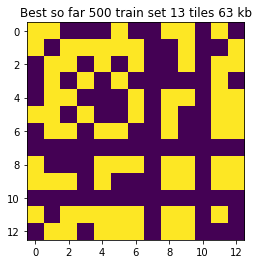

In [44]:
#print(maps_training.shape, h_init[0])
    #h_init[1, 0, :, :, :])

#PATH = 'gru_best_so_far_500trainset'
#torch.save(gru.state_dict(), PATH)

#print(h_init.shape)
plt.figure(1)
plt.imshow(key.squeeze().numpy())
plt.title('Best so far 500 train set 13 tiles ---- kb')

#print(torch.log_softmax(h_init[0], 0))
# 20 epochs dfinal + 10 = 0.025

In [79]:
#gru = GRU_WFC(num_tiles, 0, height, width, diffusion_steps_GRU, bias_scale = 0.25, deep = True)

if 0:
    with torch.no_grad():
        i1 = 88
        dfinal = diffusion_steps[i1]
        h_init = maps_training[i1, 0:int(dfinal)+1] 
        h_noise = torch.rand_like(h_init[0].clone().squeeze().unsqueeze(0))
        #print(h_init.shape, maps_training.shape)

        map_wfc_test = gru.forward(h_init[0].clone().squeeze().unsqueeze(0), 10, training = False).squeeze()
        map_wfc_noise = gru.forward(h_noise, 20, training = False).squeeze()
        
        print()
        print()
        print('map sum', map_wfc_test.sum())
        print('shapes', map_wfc_test.shape, h_init.shape)
        _, id_pred = torch.max(map_wfc_test, dim = 0)
        _, id_noise = torch.max(map_wfc_noise, dim = 0)
        _, id_gt = torch.max(h_init[h_init.shape[0]-1], dim = 0)
        _, v = validator(id_pred, key)
        print('predicted map')
        print(id_pred)
        print('Validity map')
        print(v.sum())
        print('rounded error:', (id_pred - id_gt).abs().sum())

        print(map_wfc_test[:, -1, -1])
        print(h_init[15,:,-1,-1])

        vsum = 0

v_sum = 0
width = 6
height = width
g = 0
#id_nl = torch.zeros((1000, height, width))

with torch.no_grad():
    for it in range(1):
        for k in range(100):
            h_noise = torch.rand((1, 13, height, width))
            map_wfc_noise = gru.forward(h_noise, 70, training = False).squeeze()
            _, id_noise = torch.max(map_wfc_noise, dim = 0)

            valid, v = validator(id_noise, key)
            v = torch.clamp(v, 0, 1).sum()
            v_sum += v

    
    #v_sum = (v_sum/(width*height))

#print(g,' good maps out of ', it+1)
#var, me= torch.var_mean(id_nl, dim=0)
#print('mean ', me.mean(), me.std(), ' and variance ', var.mean(), var.std())
print('Total valid points', v_sum, ' out of', 1000*36,' = ', v_sum/(1000*36),' percent correctness')
print(h_init.sum())
# https://arxiv.org/pdf/2102.09672.pdf
 

Total valid points tensor(0)  out of 36000  =  tensor(0.)  percent correctness
tensor(0., grad_fn=<SumBackward0>)


In [693]:



print(71/10000*1000,' ms per 6x6 map with 13 tiles and 20 refinement steps. Using DEAD Net small (63 kb)')
print((16*60+2.3)/10000*1000, 'ms for 10,000 32x32 with 13 tiles')
print()
p, v = validator(id_noise, key)
print(p)

print(v.sum()/(height * width), 34/36)




7.1000000000000005  ms per 6x6 map with 13 tiles and 20 refinement steps. Using DEAD Net small (63 kb)
96.22999999999999 ms for 10,000 32x32 with 13 tiles

True
tensor(1.) 0.9444444444444444


In [483]:



l_kl = torch.nn.KLDivLoss(reduction="batchmean", log_target = True)
lbce = torch.nn.BCELoss()
lbcelog = nn.BCEWithLogitsLoss(reduction="mean")



p = torch.zeros(13, 5, 5)
p[1,:,:] = 1

t = torch.zeros(13, 5, 5)
t[2,:,:] = 1

p2 = torch.zeros(13)
t2 = p2.clone()
p2[1] = 1
t2[2] = 1
print('nnn', lbcelog(p2, t.flatten(-2,-1)[:,0].squeeze()))

print(p.flatten(-2,-1)[:,0], t.flatten(-2,-1)[:,0])
print(p.flatten(-2,-1)[:,0], p2)
print(lbcelog(p.flatten(-2,-1)[:,0],t.flatten(-2,-1)[:,0]))

p = torch.log_softmax(p,0)
t = torch.log_softmax(t,0)

#print(p, t)
print(l_kl(p, t))













nnn tensor(0.7408)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.7408)
tensor(0.2245)


In [14]:
# DIFFUSION PROCESS

"""
Let's try to numerically diffuse the map into noise as the base DDPM method. 
Followed by "undoing" decisions systematically according to the surpise of a value and adding the tile
to a companion wave space indicating tiles we COULD place if we so wanted to.
0.0 Copy current collapsed map. This will be a binary map representing what can be placed.
    1. when surpise goes below a threshold we "undo" one step of collapse:
        1.2 Check legal spaces given 
    adding some value to it and all legal tiles in the wave space, then softmaxing it. 
    2. continue to diffuse with DDPM
    3. Whenever a value goes below the surprise threshold, we add 
"""



def diffuse_uncertainty(x, beta, x_key, step):
    y = torch.rand_like(x) * x_key#
    x = y*np.sqrt(1-beta) + x*np.sqrt(beta)
 
    beta += -step* x_key

    return x, torch.clamp(beta, 0, 1)

def uncollapse(wave_map, key):
    diff_map = torch.ones_like(wave_map)

    for i in range(wave_map.shape[1]):
        for j in range(wave_map.shape[2]):
            
            if j-1 >= 0:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j-1, i]))#/wave_map[:, j-1, i].sum())

            if j+1 < x.shape[1]:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j+1, i]))#/wave_map[:, j+1, i].sum())
                    
            if i-1 >= 0:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i-1]))#/wave_map[:, j, i-1].sum())

            if i+1 < x.shape[2]:
                diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i+1]))#/wave_map[:, j, i+1].sum())



    for k in range(wave_map.shape[0]):
        for i in range(wave_map.shape[1]):
            for j in range(wave_map.shape[2]):
                if diff_map[k,j,i] >= 4:
                    diff_map[k,j,i] = 1
                else:
                    diff_map[k,j,i] = 0


    return diff_map
 
#def information_uncertainty(x):

def sf(x):
    return torch.softmax(x, 0)

def information(x, xo):
    # input: wave vector
    epsilon = 0.05
    z = torch.ones(1) * x.shape[0]
    max_ent = torch.sum(torch.log2(z))
    entropy = torch.sum(-torch.log2(x)*x)

    residual = torch.ones(xo.shape[0] - x.shape[0]) * epsilon
    e_sans = torch.sum(-torch.log2(residual) * residual)

    zo = torch.ones(1) * xo.shape[0]
    max_ento = torch.sum(torch.log2(zo))
    entropyo = torch.sum(-torch.log2(xo)*xo)

    
    ii = torch.ones(1) * (x.shape[0] / xo.shape[0])
    ii_ = ii * -torch.log2(ii) + (1-ii) * -torch.log2(1-ii)

    print('---- new, old',entropy, entropyo)


    gain_ratio = (entropyo - entropy * ii - e_sans * (1 - ii)) / ii_

    print('Entropy gain', entropyo - entropy * ii)
    print('Gain ratio', gain_ratio)
    print()
    #return entropy
    



def diffuse_wrapper(map_, key, thresh, step_size):


    threshold = thresh
    beta = torch.ones_like(map_)

    x_key_mask = uncollapse(map_.clone(), key)
    
    x_key_threshold = map_.clone()
    x_ = map_.clone()
    map_unroll = map_.clone().unsqueeze(0)
    iter = 0
    while beta.sum() > 0:
        cp = beta.sum()
        x_, beta = diffuse_uncertainty(x_, beta, x_key_mask, step_size)

        for i in range(x_.shape[1]):
            for j in range(x_.shape[2]):
                entropy = torch.nonzero(x_[:,j,i])
                s = entropy.shape[0]
                entropy = torch.sum(-torch.log2((x_[entropy, j, i]))*(x_[entropy, j, i]))
                
                for k in range(x_.shape[0]):
                    if x_[k,j,i] > 0:
                        if (-torch.log2(x_[k,j,i])*x_[k,j,i] - entropy/s).abs() < threshold:
                            # Key threshold controls the validity diffusion
                            x_key_threshold[k,j,i] = 1

        # Key mask controls the noise diffusion. Masks the Beta parameter 
        x_key_mask = uncollapse(x_key_threshold, key) 

        map_unroll = torch.concat((map_unroll, x_.unsqueeze(0)), dim=0)
        if beta.sum() == cp:
            print('huh')
            break
    return map_unroll



key = gen_key(num_tiles, 6, 6)
x, i_l = gen_map(key, h, w, num_tiles)

map_train = diffuse_wrapper(x, key, 0.15, 0.025)

print(map_train.shape)




#print(d)

#x = torch.rand(4)
#x[1:4] = x[1:4] 

#y = x.clone()
#x[:-1] = torch.rand(3) * 0.2

#print('inp', x)


if 0:
    sigma = 0.05**2
    #x = torch.rand(5)
    k1 = torch.zeros(10)
    k2 = torch.zeros(10)

    k1[0:3] = 1
    k1[7:-1] = 1

    k2[2:5] = 1

    xn = torch.ones(10) * sigma
    xn[0:5] = x
    xn = sf(xn)

    xk1 = xn*k1
    xk2 = xn*k2
    xk1 = (xk1[torch.nonzero(xk1)])
    xk2 = (xk2[torch.nonzero(xk2)])

    print(xk1)
    print(xk2)

    r1 = k1.sum() / 10
    r2 = k2.sum() / 10

    ii1 = -r1*torch.log2(r1) - (1-r1)*torch.log2((1-r1))
    ii2 = -r2*torch.log2(r2) - (1-r2)*torch.log2((1-r2))

    ek1 = torch.sum(-torch.log2(xk1)*xk1) / ii1
    ek2 = torch.sum(-torch.log2(xk2)*xk2) / ii2

    print(ek1, ek2, ii1, ii2)


if 0:
    print('key 4->6')
    information( x, x_old)
    print('key 4->8')
    information( x, x_old_2)


    print('key 4->6')
    x_old_ = torch.ones(6) * 0.05
    x_old_[0:4] = x.clone() * 0.3
    information( x, x_old_)


    print('key 4->8')
    x_old_2_ = torch.ones(8) * 0.05
    x_old_2_[0:4] = x.clone() * 0.3
    information( x, x_old_2_)





NameError: name 'h' is not defined

In [234]:

#x = torch.softmax(torch.randn(5),0)
#y = torch.ones(1)*5
print('maximum entropy', -torch.log2(1/y), -torch.log2(1/y*(5/4)))

print(' cummulative entropy', torch.sum(-torch.log2(x)*x))




z = torch.ones(4)
z = x[0:4].clone()
zhigh = x[1:5].clone()
print('z low', z, 'z high', zhigh)
#z = torch.softmax(z,0)
#zhigh = torch.softmax(zhigh,0)


print(' probabilities', x, z, zhigh)
print('GINI pre', 1 - torch.sum(x**2))
print('GINI collapse low', 1 - torch.sum(z**2))
print('GINI collapse high', 1 - torch.sum(zhigh**2))


print(' delta E', torch.sum(-torch.log2(x)*x), torch.sum(-torch.log2(z)*z),  torch.sum(-torch.log2(zhigh)*zhigh))



maximum entropy tensor([-0.1557, -0.7224, -0.2991, -0.3245]) tensor([-0.4776, -1.0443, -0.6210, -0.6465])
 cummulative entropy tensor(nan)
z low tensor([[[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]]) z high tensor([[[0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]],

        [[0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 0.]]])
 probabilities tensor([[[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
      

In [125]:
# INFORMATION GAIN EXPERIMENTS

def entropy_gain(x, query, y):
    t = 0


p = torch.ones(4)
p[0] = 0.7
p[1] = 0.2
p[2] = 0.05
p[3] = 0.05

p1 = p[2:4]
p1rem = p[0:2]
p2 = p[0:3]
p2rem = p[3]
print('splits', p1, p2)


sup1 = torch.sum(torch.log2(1/p1)*p1)
sup2 = torch.sum(torch.log2(1/p2)*p2)

print(sup1, sup2)


if 0:

    r1 = p1.shape[0]/p.shape[0]
    r2 = p2.shape[0]/p.shape[0]

    ent = torch.sum(-torch.log2(p)*p)
    ep1 = torch.sum(-torch.log2(p1)*p1)  #- (1-r1)*torch.sum(p1rem * torch.log2(p1rem))*0
    ep2 = torch.sum(-torch.log2(p2)*p2)  #- (1-r2)*torch.sum(p2rem * torch.log2(p2rem))*0

    d = torch.ones(1) * p.shape[0]

    d1 = -r1*torch.log2(p1.shape[0]/d) #- (1-r1)*torch.log2(1-p1.shape[0]/d)
    d2 = -r2*torch.log2(p2.shape[0]/d) #- (1-r2)*torch.log2(1-p2.shape[0]/d)


    ig1 = (ent - ep1 * r1)
    ig2 =  (ent - ep2 * r2)
    print('Information gain', ent, ig1, ig2)
    print()
    if ig1 > ig2:
        print('Reduce surprise by choosing split using key p1', ig1)
    else:
        print('Reduce surprise by choosing split using key p2', ig2)

    print()
    print('ii', d1, d2)

    print('gain ratios [p1, p2]', ig1/d1, ig2/d2)



splits tensor([0.0500, 0.0500]) tensor([0.7000, 0.2000, 0.0500])
tensor(0.4322) tensor(1.0407)


In [ ]:
# DISCRIMINATOR EXPERIMENTS

check_map = torch.zeros((height, width))

val, id = torch.max(map_wfc.flatten(-2,-1),dim=1)
#print(id)
id_map = id.reshape(10,10)


class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1,16, 5, 2, 2)
        self.c2 = nn.Conv2d(1, 16, 5, 2, 2)

        self.c3 = nn.Conv2d(16,16,3,1,1)
        self.c4 = nn.Conv2d(16,16,3,1,1)

        self.c5 = nn.Conv2d(32, 16, 3, 1, 1)

        self.p1 = nn.Conv2d(16,1,1)
        self.p2 = nn.Conv2d(16,1,1)

        self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        self.cup = nn.ConvTranspose2d(16, 1, 3, 2)
        self.pad = nn.ZeroPad2d(1)
        self.readout = nn.Conv2d(49,1,3,1,1)

        self.sigma = self.func #nn.Sigmoid()
        self.phi = self.func #nn.Tanh()
        self.rel = nn.ReLU() #nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

        self.cc1 = nn.Conv2d(1,1,3,1,0)
        self.cc2 = nn.Conv2d(1,1,3,1,0)
        self.cc3 = nn.Conv2d(1,1,3,1,0)
        self.cc4 = nn.Conv2d(1,1,3,1,0)

        self.cp = nn.Conv2d(4,2,1)

    def forward(self, x):
        if 0:
            # Reduce
            y = self.c1(x)
            z = self.c2(x)
            # Permute
            zz = self.rel(self.c4(z))
            yy = self.c3(self.phi(y))
            pz = self.sigma(self.p1(zz))
            # Gate
            yz = torch.concat((yy, zz), dim=0)
            yz = self.c5(yz)
            xx = zz * pz + (1 - pz) * yz
            # Expand
            xc = self.up(yy.unsqueeze(0))
            xx = self.p2(self.up(zz.unsqueeze(0)))
            pred = torch.concat((xx, xc, self.up(y.unsqueeze(0)), self.up(z.unsqueeze(0))),dim=1)
            pred = self.sigmoid(self.readout(pred))

        x1 = self.cc1(x)
        x2 = self.rel(self.cc2(x))
        x3 = self.cc3(x)
        x4 = self.rel(self.cc4(x))
        xx = torch.concat((x1,x2,x3,x4), dim = 0)
        pred = self.cp(xx)

        return pred
    
    def func(self, x):
        return x

batch_size = 1
epochs = 1
loss = 0

width = 4 
height = 4

l_func = nn.MSELoss()
disc = discriminator()
optimizer_disc = torch.optim.SGD(disc.parameters(), lr = 0.0001)

edge_loss = torch.zeros((3,3))
edge_loss[:,0] = -1
edge_loss[:,2] = 1
edge_loss[1,0] = -2
edge_loss[1,2] = 2
edge_loss = edge_loss.unsqueeze(0)

block = torch.zeros((2,4,4))
block[1,:,:] = 1

pad = torch.nn.ZeroPad2d(1)

for e in range(epochs):
    id_map_rand = torch.randint(0, 2, (width,height))
    id_check = id_map_rand
    check_map = torch.zeros((height, width))

    for i in range(width):
        for j in range(height):
            tile = id_check[j,i]
            n1 = n2 = n3 = n4 = -1
            if j > 0:
                n1 = id_check[j-1,i]
            if j < height-1:
                n2 = id_check[j+1,i]
            if i > 0:
                n3 = id_check[j,i-1]
            if i < width-1:
                n4 = id_check[j,i+1]

            vec = torch.from_numpy(np.array((n1,n2,n3,n4)))
            
            for k in range(4):
                if vec[k] > -0.5:
                    check_map[j,i] += key[tile, vec[k]]
            
    
    pred = disc.forward(id_map_rand.unsqueeze(0).float()).squeeze()

    #loss += (((check_map - (pred*4.0).round()).abs()/4.0).sum())/2.0
    loss += l_func((pred), (check_map).detach().squeeze()) # + (((check_map - (pred*4.0).round()).abs()/4.0).sum())

    edg_pred = nn.functional.conv2d((pred).unsqueeze(0).unsqueeze(0), edge_loss.unsqueeze(0), padding = 0)
    edg_pred += nn.functional.conv2d((pred).unsqueeze(0).unsqueeze(0), edge_loss.transpose(-2,-1).unsqueeze(0), padding = 0)
    edg_gt = nn.functional.conv2d((check_map/4.0).unsqueeze(0).unsqueeze(0), edge_loss.unsqueeze(0), padding = 0)
    loss += ((18-edg_pred) / 18.0).mean()

    if e%(500) == 0 and e > 0:        
        print('Avg loss:', loss.detach().numpy()/batch_size)

    if e%batch_size == 0 and e > 0:
        optimizer_disc.zero_grad()
        loss = loss / batch_size
        loss.backward()
        optimizer_disc.step()
        del loss
        loss = 0







print(check_map.sum())
print('Greater number is better')
plt.figure(1)
plt.imshow((check_map/4.0).numpy())
plt.colorbar()

plt.figure(2)
plt.imshow((pred).squeeze().detach().numpy())
plt.colorbar()

plt.figure(3)
plt.imshow((nn.functional.conv2d((pred).unsqueeze(0).unsqueeze(0), edge_loss.unsqueeze(0), padding = 0)).squeeze().detach().numpy())
plt.colorbar()


/Users/nathanstruble/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([4, 4])) that is different to the input size (torch.Size([2, 2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 2

In [814]:



class autoencdoer(nn.Module):
    def __init__(self, w, h):
        super().__init__()

        self.width = w
        self.height = h
        self.c1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.c2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.c3 = nn.Conv2d(32, 32, 3, 2, 1)
        self.c4 = nn.Conv2d(32, 16, 1)
        op = int((w/8 * h /8 * 16))
        redux = w//2 * h //2
        self.l1 = nn.Linear(op, redux)
        self.l2 = nn.Linear(redux, redux)
        self.l3 = nn.Linear(redux, op)
        self.sigma = nn.ReLU()
        self.pad = nn.ZeroPad2d(1)


        self.u1 = nn.ConvTranspose2d(32, 32, 3, 2, 2)
        self.u2 = nn.ConvTranspose2d(32, 32, 3, 2, 1)
        self.u3 = nn.ConvTranspose2d(32, 32, 4, 2, 2)
        self.readout = nn.Conv2d(32, 1, 1)
        self.sigma = nn.Sigmoid()

    def forward(self, x):
        x = self.encode(x)
        x = self.latent(x)
        x = self.decode(x)
        
        return x

    def encode(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c4(x)
        
        return x

    def latent(self, x):
        y = x.reshape(x.shape[0], -1)
        y = self.l1(y)
        y = self.sigma(self.l2(y))
        y = self.l3(y)
        x = self.pad((y.reshape(x.shape) + x)/2.0)

        return x

    def decode(self, x):
        x = self.u1(x)
        x = self.u2(x)
        x = self.u3(x)
        
        x = self.sigma(self.readout(x))

        return x



class autoencoder16x16(nn.Module):
    def __init__(self):
        super().__init__()

        r = 16*16

        self.l1 = nn.Linear(r, r)
        self.l2 = nn.Linear(r, r//2)
        self.l3 = nn.Linear(r//2, r//2)
        self.l4 = nn.Linear(r//2, r//4)
        self.l5 = nn.Linear(r//4, r//4)

        self.sigmoid = nn.Sigmoid()
        self.rel = nn.LeakyReLU()

        self.invl5 = nn.Linear(r//4, r//4)
        self.invl4 = nn.Linear(r//4*2, r//2)
        self.invl3 = nn.Linear(r//2*2, r//2)
        self.invl2 = nn.Linear(r//2*2, r//2)
        self.invl1 = nn.Linear(r//2, r)

        self.bn1 = nn.BatchNorm1d(64*2)
        self.bn2 = nn.BatchNorm1d(128*2)

        self.drop = nn.Dropout(0.3)
        

    def forward(self, x, b):
        x1, x2, x3, x4, x5 = self.encode(x)
        y = self.decode(x2, x3, x4, x5, b)

        return y

    def encode(self, x):

        x1 = self.l1(x)
        x2 = self.l2(x1)
        x3 = self.l3(x2)
        x4 = self.l4(x3)
        x5 = self.l5(x4)

        return x1, x2, x3, x4, self.rel(x5)

    def decode(self, x2, x3, x4, x5, b):
        
        v = torch.concat((self.invl5(x5), x4), dim=2).squeeze()
     
        y5 = self.bn1(v).reshape(b,-1).squeeze()
        vv = torch.concat((self.invl4(y5), x3.squeeze()), dim=1)
        y4 = self.drop(self.bn2(vv).reshape(b,-1))
        v2 = self.invl3(y4)
        y3 = torch.concat((v2, x2.squeeze()), dim=1).reshape(b,-1)
        y2 = self.invl2(y3)
        y1 = self.sigmoid(self.invl1(y2).squeeze())

        return y1

        
        
        





In [716]:

numt_tiles = 13
h = 16
w = 16
train_size = 50
valid_size = 15
test_size = 10

if 0:

    map_list = torch.zeros(train_size, numt_tiles, h, w)
    id_map_list = torch.zeros(train_size, h, w)

    map_list_v = torch.zeros(valid_size, numt_tiles, h, w)
    id_map_list_v = torch.zeros(valid_size, h, w)

    map_list_t = torch.zeros(test_size, numt_tiles, h, w)
    id_map_list_t = torch.zeros(test_size, h, w)

    key = gen_key(num_tiles, 6, 6)
    m_l, i_l = gen_map(key, h, w, numt_tiles)

    for k in range(train_size):
        m_l, i_l = gen_map(key, h, w, numt_tiles)
        map_list[k] = m_l
        id_map_list[k] = i_l
        


    for k in range(valid_size):
        m_l, i_l = gen_map(key, h, w, numt_tiles)
        map_list_v[k] = m_l
        id_map_list_v[k] = i_l
        



    for k in range(test_size):
        m_l, i_l = gen_map(key, h, w, numt_tiles)
        map_list_t[k] = m_l
        id_map_list_t[k] = i_l
        



In [686]:

print(map_list.type())
index = np.arange(50)
np.random.shuffle(index)

i = int(index[int(b + i2*batch_size)])


print(i)

m = map_id_list[i].clone()

print(m.shape)


torch.FloatTensor
17
torch.Size([13, 16, 16])


In [818]:

hh = 16
epochs = 1000
batch_size = 10
auto = autoencoder16x16()
optimizer_auto = torch.optim.NAdam(auto.parameters(), lr = 0.005)
loss = nn.L1Loss()

index = np.arange(train_size)

print(map_list.shape)

for i1 in range(epochs):
    np.random.shuffle(index)
    l_sum = 0

    for i2 in range(train_size // batch_size):
        
        with torch.no_grad():
            map_batch = torch.zeros((batch_size, 16 * 16))
            for b in range(batch_size):
                m = id_map_list[index[b + i2*batch_size]].clone().squeeze().reshape(1,-1)  / num_tiles
                map_batch[b] = m
       
        out = auto.forward(map_batch.unsqueeze(1), b+1)
        out = out.round()
        
        l_ = loss(out.squeeze(), map_batch)

        l_sum += l_.clone().detach().numpy()

        optimizer_auto.zero_grad()
        l_.backward()
        optimizer_auto.step()

        del l_
    
    
    if i1 % 20 == 0 and i1 > 0:

        if i1 % 100 == 0:
            print('training loss epoch', i1, '=', l_sum/(5))

        l_sum = 0

        
        with torch.no_grad():
            map_batch = torch.zeros((valid_size, 16 * 16))
            for b in range(valid_size):
                m = id_map_list_v[b].clone().squeeze().reshape(1,-1) / num_tiles
                map_batch[b] = m
            
        out = auto.forward(map_batch.unsqueeze(1), b+1)
        l_ = loss(out.squeeze(), map_batch)

        l_sum += l_.clone().detach().numpy()

        optimizer_auto.zero_grad()
        l_.backward()
        optimizer_auto.step()

        del l_

        if i1 % 100 == 0:
            print('Validation loss for epoch',i1,'=', l_sum)

        l_sum = 0

        with torch.no_grad():
            map_batch = torch.zeros((test_size, 16 * 16))
            for b in range(test_size):
                m = id_map_list_v[b].clone().squeeze().reshape(1,-1) / num_tiles
                map_batch[b] = m
                
            out = auto.forward(map_batch.unsqueeze(1), b+1)
            l_ = loss(out.squeeze(), map_batch)
            l_sum += l_.clone().detach().numpy()

            del l_
            
            if i1 % 100 == 0:
            
                print('Testing error',l_sum)





torch.Size([50, 13, 16, 16])
training loss epoch 100 = 0.503515613079071
Validation loss for epoch 100 = 0.47304126620292664
Testing error 0.47878599166870117
training loss epoch 200 = 0.4965384781360626
Validation loss for epoch 200 = 0.49515411257743835
Testing error 0.4843924045562744
training loss epoch 300 = 0.4979206740856171
Validation loss for epoch 300 = 0.503585696220398
Testing error 0.4946514070034027
training loss epoch 400 = 0.49871997237205506
Validation loss for epoch 400 = 0.5229532122612
Testing error 0.516826868057251
training loss epoch 500 = 0.4996274054050446
Validation loss for epoch 500 = 0.5066304802894592
Testing error 0.49765628576278687
training loss epoch 600 = 0.49963942766189573
Validation loss for epoch 600 = 0.506290078163147
Testing error 0.49765628576278687
training loss epoch 700 = 0.49963942766189573
Validation loss for epoch 700 = 0.506290078163147
Testing error 0.49765628576278687
training loss epoch 800 = 0.499609375
Validation loss for epoch 800

In [ ]:

# Failed auto encoders :()

class AE(torch.nn.Module):
    def __init__(self, num_tiles, bat):
        super().__init__()

        self.ntiles = num_tiles
        self.bs = bat

        self.key_1 = torch.nn.Linear(num_tiles, num_tiles//2)
        self.key_2 = torch.nn.Linear(num_tiles, num_tiles//2)
        self.key_11 = torch.nn.Linear(num_tiles//2, num_tiles//4)
        self.key_22 = torch.nn.Linear(num_tiles//2,num_tiles//4)
        self.key_conv_1 = torch.nn.Conv2d(1,1,3,2,1)
        self.key_conv_2 = torch.nn.Conv2d(1,1,3,2,1)
        self.key_conv_3 = torch.nn.Conv2d(1,1,3,2,1)

        self.lin1 = torch.nn.Linear((num_tiles//8)**2, num_tiles)
        self.lin2 = torch.nn.Linear(num_tiles, num_tiles)
        self.lin3 = torch.nn.Linear(num_tiles, num_tiles)
        self.relu = torch.nn.LeakyReLU()
        self.sig = torch.nn.Sigmoid()

        self.square_lin = torch.nn.Linear(num_tiles, (num_tiles+num_tiles%2))
        self.up_conv1 = torch.nn.Conv2d(2,2,3,1)
        self.up_conv2 = torch.nn.Conv2d(2,1,3,1)
        self.up_conv3 = torch.nn.Conv2d(1,1,3,1)
        self.up_conv4 = torch.nn.Conv2d(1,1,3,1)
        self.up_conv5 = torch.nn.Conv2d(1,1,3,1,1)

        self.upscale = torch.nn.UpsamplingBilinear2d(scale_factor = 2)

    def encode(self, x):
        
        key = x
        row_ = self.key_11(self.key_1(key))
        i1 = self.key_2(key.transpose(-2,-1))
        col_ = self.key_22(i1)
        cross_ = torch.matmul(row_,col_.transpose(-2,-1))
        redux = self.key_conv_3(self.key_conv_2((self.key_conv_1(cross_))))

        return redux
    
    def latent(self, x):
        
        o1 = (self.lin1(x.reshape(self.bs, -1).squeeze()))
        o2 = self.lin2(o1)
        o3 = (self.lin3(o2))

        return o3

    def decode(self, x):

        x = self.square_lin(x)
        x = x.reshape(self.bs,2, int(np.sqrt(x.shape[1]//2)), -1)
        u1 = self.up_conv1(x)
        u1_up = self.upscale(u1)
        u2 = self.up_conv2(u1_up)
        u2_up = self.upscale(u2)
        u3 = self.up_conv3(u2_up)
        u3_up = self.upscale(u3)
        u4 = self.up_conv4(u3_up)
        u4_up = self.upscale(u4)
        u5 = self.up_conv5(u4_up)
        u5_up = self.sig(self.upscale(u5))

        return u5_up
    
    def forward(self, x):

        encoded = self.encode(x)
        latent = self.latent(encoded)
        decoded = self.decode(latent)

        return decoded


class AE2(torch.nn.Module):
    def __init__(self, batch_size, num_tiles):
        super().__init__()
        self.bs = batch_size
        self.key_1 = torch.nn.Linear(num_tiles, num_tiles//2)
        self.key_2 = torch.nn.Linear(num_tiles, num_tiles//2)
        self.key_11 = torch.nn.Linear(num_tiles//2, num_tiles//4)
        self.key_22 = torch.nn.Linear(num_tiles//2,num_tiles//4)       
        self.key_111 = torch.nn.Linear(num_tiles//4, num_tiles//4)
        self.key_222 = torch.nn.Linear(num_tiles//4,num_tiles//4)    

        self.lin1 = torch.nn.Linear((num_tiles//4)**2, ((num_tiles//4)**2))
        self.lin2 = torch.nn.Linear(((num_tiles//4)**2), ((num_tiles//4)**2))
        self.relu = torch.nn.LeakyReLU()

        self.upconv = torch.nn.UpsamplingNearest2d(scale_factor=2)
        self.mx = torch.nn.AdaptiveMaxPool2d((50,50))
        self.conv1 = torch.nn.Conv2d(1,1,3,1,1)
        self.conv2 = torch.nn.Conv2d(1,1,3,1,2)
        self.conv3 = torch.nn.Conv2d(1,1,3,1,1)

        self.sig = torch.nn.Sigmoid()
        

    def encode(self,x):
        key = x
        row_ = self.key_111(self.key_11(self.key_1(key)))
        col_ = self.key_222(self.key_22(self.key_2(key.transpose(-2,-1))))
        mul = torch.matmul(row_.transpose(-2,-1),col_)
        return mul
    
    def latent(self, x):
        
        x = self.relu(self.lin1(x.reshape(self.bs,-1)))
        x = self.lin2(x)
        return x
    
    def decode(self, x):

        x = x.reshape(self.bs, int(np.sqrt(x.shape[1])), -1).unsqueeze(1)
        x = self.upconv(x)
        x = self.conv1(x)
        x = self.upconv(x)
        
        x = self.conv2(x)
        x = self.upconv(x)
        x = self.mx(x)
        x = self.conv3(x)

        return self.sig(x)

    def forward(self, x):

        x = self.encode(key)
        lat = self.latent(x)
        d = self.decode(lat)

        return d

        


In [978]:


class ae(nn.Module):
    def __init__(self):
        latent = 1
        super().__init__()
        self.f1 =  nn.Linear(3, latent, bias = False)
        self.f2 = nn.Linear(latent, 3)
        self.act = self.pc #nn.ReLU()


    def forward(self, x):
        return self.f2(self.act(self.f1(x)))
    
    def pc(self,x):
        return x

enc = ae()

opt = torch.optim.SGD(enc.parameters(), lr = 0.01)
l = nn.L1Loss()


x = torch.zeros((10,3))

loss = 0

# 1000,000 iterations
for i in range(10000):
    with torch.no_grad():
        x[:] = torch.randint(0,2,(10,1)).float()
        x[:,1] = 1-x[:,0]
        x[:,2] = x[:,0]

    y = enc(x)
    loss = l(y,x)

    if 1:
        opt.zero_grad()
        (loss).backward()
        opt.step()



print(loss)




tensor(0.0052, grad_fn=<L1LossBackward0>)
